In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torchvision.datasets import STL10 as dataset
import time
from tqdm import tqdm
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
import shutil
import glob
from torch.utils.data import Dataset, DataLoader

device

device(type='cuda')

## Data

In [2]:
data_path = os.path.expanduser('~/data')
os.makedirs(data_path, exist_ok=True)
download = 'stl10_binary.tar.gz' not in os.listdir(data_path)
download, os.listdir(data_path)

(False,
 ['delta_datasets',
  'train_delta_dataset.pkl',
  'stl10_binary',
  'models',
  'loss_deltas',
  'stl10_binary.tar.gz'])

### Transformers 🤖

In [3]:
class DualTransformDataset(Dataset):
    def __init__(self, dataset, transform, transform_alpha):
        """
        A custom dataset that applies two different transforms to each image.

        Args:
            dataset (Dataset): The base dataset to use (e.g., STL10, CIFAR-10).
            transform (callable): The first transformation to apply.
            transform_alpha (callable): The second transformation to apply.
        """
        self.dataset = dataset
        self.transform = transform
        self.transform_alpha = transform_alpha

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]  # Get the original image and label
        image1 = self.transform(image) if self.transform else image
        image2 = self.transform_alpha(image) if self.transform_alpha else image
        return image1, image2, label

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std
])

transform_alpha = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),  # Increase Gaussian noise (was 0.01)
    transforms.GaussianBlur(kernel_size=5, sigma=(2.0, 5.0)),  # Apply Gaussian blur
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

### Data loaders

In [5]:
# Download and load the training dataset
train_dataset = datasets.STL10(root=data_path, split='train', download=download, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = datasets.STL10(root=data_path, split='test', download=download, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:


# Load the CIFAR-10 dataset with the transformations
train_dataset_alpha = datasets.STL10(root=data_path, split='train', download=False, transform=transform_alpha)
train_loader_alpha = DataLoader(train_dataset_alpha, batch_size=64, shuffle=False)


# Download and load the testing dataset
test_dataset_alpha = datasets.STL10(root=data_path, split='test', download=False, transform=transform_alpha)
test_loader_alpha = DataLoader(test_dataset_alpha, batch_size=64, shuffle=False)


In [7]:
train_nont_dataset = datasets.STL10(root=data_path, split='train', download=False, transform=None)
train_dual_dataset = DualTransformDataset(train_nont_dataset, transform, transform_alpha)
train_dual_loader = DataLoader(train_dual_dataset, batch_size=64, shuffle=True, num_workers=4)

test_nont_dataset = datasets.STL10(root=data_path, split='test', download=False, transform=None)
test_dual_dataset = DualTransformDataset(test_nont_dataset, transform, transform_alpha)
test_dual_loader = DataLoader(test_dual_dataset, batch_size=64, shuffle=True, num_workers=4)



### Show images

In [8]:
# Display a few sample images from the training dataset
def show_images(data_loader):
    # Get a batch of images
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Unnormalize and plot
    images = images / 2 + 0.5  # Unnormalize
    grid = torchvision.utils.make_grid(images[:8])  # Take first 8 images
    plt.figure(figsize=(10, 4))
    plt.imshow(grid.permute(1, 2, 0))  # Permute dimensions for plotting
    plt.axis('off')
    plt.show()

# Show some images

In [9]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert CHW to HWC for plotting
    plt.axis('off')
    plt.show()


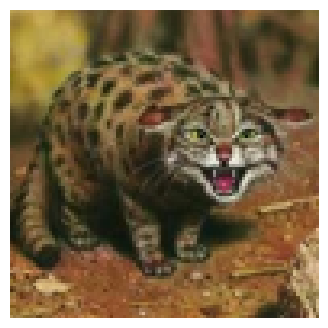

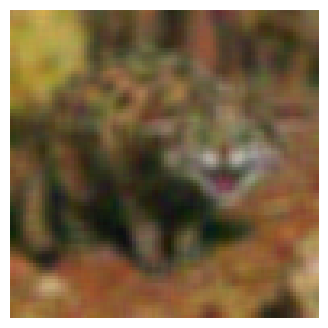

In [10]:
# images, _ = next(iter(train_loader))
# images_alpha, _ = next(iter(train_loader_alpha))
images,images_alpha, _ = next(iter(train_dual_loader))
i = 11
imshow(images[i])
imshow(images_alpha[i])


## Train

In [27]:
def get_new_model():
  model = models.resnet18(weights=True)

  # Modify the fully connected layer to match STL10 classes
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, 10)  # STL10 has 10 classes

  # Move the model to the appropriate device (GPU if available)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  return {'model': model, 'criterion': criterion, 'optimizer': optimizer}

In [28]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        # Initialize tqdm progress bar
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Update tqdm bar with current loss
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Time: {time.time() - start_time:.2f}s")

    print("Training complete")

In [47]:
def get_losses(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    losses = []
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    losses = np.array(losses)
    return {'losses': losses, 'mean': np.mean(losses), 'std': np.std(losses)}


In [29]:
model_dict = get_new_model()
model = model_dict['model']
criterion = model_dict['criterion']
optimizer = model_dict['optimizer']

model_alpha_dict = get_new_model()
model_alpha = model_alpha_dict['model']
criterion_alpha = model_alpha_dict['criterion']
optimizer_alpha = model_alpha_dict['optimizer']

/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
def run_train(train_loader, model_dict=None, name='model', save_path=data_path, num_epochs=10):
    if model_dict is None:
        model_dict = get_new_model()

    train_model(model_dict['model'], train_loader_alpha, model_dict['criterion'], model_dict['optimizer'], num_epochs=num_epochs)
    model_dict['losses'] = model_dict.get('losses') or {}
    model_dict['losses']['train'] = get_losses(model_dict['model'], train_loader, model_dict['criterion'])
    if save_path:
        with open(f"{data_path}/models/{name}_dict_{round(time.time())}.pkl", "wb") as f:
            pickle.dump(model_dict, f)
            shutil.copy(f.name, f"{data_path}/models/{name}_dict.pkl")
    
    return model_dict

In [39]:
model_dict = run_train(train_loader, name='model', num_epochs=10)

Epoch 1/10: 100%|██████████| 79/79 [00:43<00:00,  1.82it/s, loss=1.89] 


Epoch 1/10, Loss: 1.0825, Time: 43.35s


Epoch 2/10: 100%|██████████| 79/79 [00:40<00:00,  1.97it/s, loss=0.914]


Epoch 2/10, Loss: 0.6999, Time: 40.02s


Epoch 3/10: 100%|██████████| 79/79 [00:35<00:00,  2.22it/s, loss=0.074]


Epoch 3/10, Loss: 0.4409, Time: 35.67s


Epoch 4/10: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s, loss=0.086]


Epoch 4/10, Loss: 0.3521, Time: 38.34s


Epoch 5/10: 100%|██████████| 79/79 [00:36<00:00,  2.15it/s, loss=0.0434]


Epoch 5/10, Loss: 0.3010, Time: 36.69s


Epoch 6/10: 100%|██████████| 79/79 [00:39<00:00,  1.98it/s, loss=0.0223]


Epoch 6/10, Loss: 0.2106, Time: 39.93s


Epoch 7/10: 100%|██████████| 79/79 [00:37<00:00,  2.09it/s, loss=0.0139]


Epoch 7/10, Loss: 0.1478, Time: 37.84s


Epoch 8/10: 100%|██████████| 79/79 [00:38<00:00,  2.06it/s, loss=0.00129]


Epoch 8/10, Loss: 0.1208, Time: 38.41s


Epoch 9/10: 100%|██████████| 79/79 [00:37<00:00,  2.08it/s, loss=0.00229]


Epoch 9/10, Loss: 0.1069, Time: 37.99s


Epoch 10/10: 100%|██████████| 79/79 [00:38<00:00,  2.03it/s, loss=0.00154]


Epoch 10/10, Loss: 0.1026, Time: 38.86s
Training complete


100%|██████████| 79/79 [00:07<00:00, 10.35it/s]


In [40]:
model_alpha_dict = run_train(train_loader_alpha, name='model_alpha', num_epochs=10)

/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 79/79 [00:39<00:00,  2.00it/s, loss=1.57] 


Epoch 1/10, Loss: 1.1436, Time: 39.62s


Epoch 2/10: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s, loss=1.13] 


Epoch 2/10, Loss: 0.6791, Time: 38.12s


Epoch 3/10: 100%|██████████| 79/79 [00:36<00:00,  2.17it/s, loss=0.0863]


Epoch 3/10, Loss: 0.4561, Time: 36.49s


Epoch 4/10: 100%|██████████| 79/79 [00:38<00:00,  2.03it/s, loss=0.0168]


Epoch 4/10, Loss: 0.3583, Time: 38.88s


Epoch 5/10: 100%|██████████| 79/79 [00:38<00:00,  2.04it/s, loss=0.0257]


Epoch 5/10, Loss: 0.2474, Time: 38.79s


Epoch 6/10: 100%|██████████| 79/79 [00:37<00:00,  2.11it/s, loss=0.00626]


Epoch 6/10, Loss: 0.1997, Time: 37.42s


Epoch 7/10: 100%|██████████| 79/79 [00:35<00:00,  2.21it/s, loss=0.011] 


Epoch 7/10, Loss: 0.1707, Time: 35.81s


Epoch 8/10: 100%|██████████| 79/79 [00:35<00:00,  2.24it/s, loss=0.0187]


Epoch 8/10, Loss: 0.1205, Time: 35.27s


Epoch 9/10: 100%|██████████| 79/79 [00:36<00:00,  2.19it/s, loss=0.0052]


Epoch 9/10, Loss: 0.1009, Time: 36.04s


Epoch 10/10: 100%|██████████| 79/79 [00:38<00:00,  2.04it/s, loss=0.00369]


Epoch 10/10, Loss: 0.1233, Time: 38.80s
Training complete


100%|██████████| 79/79 [00:37<00:00,  2.13it/s]


## Eval

### Reload models

In [11]:
# Load the models
model_names = ['model', 'model_alpha']
models = {}
for model_name in model_names:
    try:
        with open(f"{data_path}/models/{model_name}_dict.pkl", "rb") as f:
            models[model_name] = pickle.load(f)
        print(f"Loaded {model_name} model from: {data_path}/models/{model_name}_dict.pkl")
    except FileNotFoundError:
        print(f"Error: Could not find {model_name} model file in {data_path}/models/")
    except Exception as e:
        print(f"An error occurred while loading {model_name} model: {e}")

Loaded model model from: /home/paperspace/data/models/model_dict.pkl
Loaded model_alpha model from: /home/paperspace/data/models/model_alpha_dict.pkl


In [29]:
model_dict = models['model']
model_alpha_dict = models['model_alpha']
model, model_alpha = model_dict['model'], model_alpha_dict['model']

### Calculate Losses

In [76]:
def calculate_loss_deltas(data_loader, data_loader_alpha, model, model_alpha, criterion):
    model.eval()  # Set both models to evaluation mode
    model_alpha.eval()

    loss_deltas = []
    i = 0
    for (inputs, labels), (inputs_alpha, _) in tqdm(zip(data_loader, data_loader_alpha)):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs_alpha = inputs_alpha.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            outputs_alpha = model_alpha(inputs_alpha)
            loss_alpha = criterion(outputs_alpha, labels)

            loss_delta = loss_alpha - loss
            loss_deltas.append(loss_delta)
            i += 1
    loss_deltas = torch.cat(loss_deltas, dim=0)
    return loss_deltas

In [80]:
# Calculate loss deltas for train and test data loaders
train_loss_deltas = calculate_loss_deltas(train_loader, train_loader_alpha, model_dict['model'], model_alpha_dict['model'], nn.CrossEntropyLoss(reduce=False))
test_loss_deltas = calculate_loss_deltas(test_loader, test_loader_alpha, model_dict['model'], model_alpha_dict['model'], nn.CrossEntropyLoss(reduce=False))

/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
125it [01:38,  1.26it/s]


In [88]:
# Save the loss deltas
deltas = {
    'train_loss_deltas': train_loss_deltas,
    'test_loss_deltas': test_loss_deltas
}

deltas_path = os.path.join(data_path, 'loss_deltas')
os.makedirs(deltas_path, exist_ok=True)

with open(f"{deltas_path}/loss_deltas.pkl", "wb") as f:
    pickle.dump(deltas, f)
    print(f"Saved loss deltas to {deltas_path}/loss_deltas.pkl")

Saved loss deltas to /home/paperspace/data/loss_deltas/loss_deltas.pkl


# Delta

### Delta Dataloader

In [89]:
# Check if loss deltas are already in memory
if 'train_loss_deltas' not in globals() or 'test_loss_deltas' not in globals():
    # Load the loss deltas from disk
    deltas_path = os.path.join(data_path, 'loss_deltas', 'loss_deltas.pkl')
    with open(deltas_path, "rb") as f:
        deltas = pickle.load(f)
        train_loss_deltas = deltas['train_loss_deltas']
        test_loss_deltas = deltas['test_loss_deltas']
        print(f"Loaded loss deltas from {deltas_path}")

In [90]:
class DeltaLossDataset(Dataset):
    def __init__(self, dataset, dataset_alpha, loss_deltas):
        self.dataset = dataset
        self.dataset_alpha = dataset_alpha
        self.loss_deltas = loss_deltas

        # Ensure the length of loss_deltas matches the length of the dataset
        assert len(self.loss_deltas) == len(self.dataset), "Length of loss_deltas must match the length of the dataset"

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        image_alpha, _ = self.dataset_alpha[idx]
        loss_delta = self.loss_deltas[idx]
        return image, image_alpha, loss_delta


In [96]:

# Create new data loaders with delta loss as the label
train_delta_dataset = DeltaLossDataset(train_dataset, train_dataset_alpha, train_loss_deltas)
test_delta_dataset = DeltaLossDataset(test_dataset, test_dataset_alpha, test_loss_deltas)


In [99]:
# Create data loaders for the delta datasets
train_delta_loader = DataLoader(train_delta_dataset, batch_size=128, shuffle=True, num_workers=4)
test_delta_loader = DataLoader(test_delta_dataset, batch_size=128, shuffle=False, num_workers=4)

In [102]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [105]:

import os

# Set the CUDA_LAUNCH_BLOCKING environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Perform a dry run of the dataloader
def dry_run_dataloader(dataloader, num_batches=1):
    for batch_idx, (inputs, inputs_alpha, loss_deltas) in enumerate(dataloader):
        print(f"Batch {batch_idx + 1}")
        print(f"Inputs shape: {inputs.shape}")
        print(f"Inputs alpha shape: {inputs_alpha.shape}")
        print(f"Loss deltas shape: {loss_deltas.shape}")
        if batch_idx + 1 >= num_batches:
            break

# Dry run the train delta loader
dry_run_dataloader(train_delta_loader, num_batches=3)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_2216/2043752173.py", line 16, in __getitem__
    loss_delta = self.loss_deltas[idx]
RuntimeError: CUDA error: initialization error
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



## Train Delta

In [45]:
# Define the delta model using a pretrained ResNet18
class DeltaModel(nn.Module):
    def __init__(self):
        super(DeltaModel, self).__init__()
        self.resnet = torchvision.models.resnet18(weights = torchvision.models.resnet.ResNet18_Weights)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 1)  # Predict a single value (delta loss)

    def forward(self, x):
        return self.resnet(x)


In [46]:

# Initialize the delta model, criterion, and optimizer
delta_model = DeltaModel().to(device)
criterion_delta = nn.MSELoss()
optimizer_delta = optim.Adam(delta_model.parameters(), lr=0.001)


In [47]:

# Function to train the delta model
def train_delta_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        # Initialize tqdm progress bar
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (inputs, inputs_alpha, loss_deltas) in progress_bar:
            inputs, inputs_alpha, loss_deltas = inputs.to(device), inputs_alpha.to(device), loss_deltas.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), loss_deltas)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Update tqdm bar with current loss
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Time: {time.time() - start_time:.2f}s")

    print("Training complete")


In [48]:

# Train the delta model
train_delta_model(delta_model, train_delta_loader, criterion_delta, optimizer_delta, num_epochs=1)

Epoch 1/10:   0%|          | 0/79 [00:00<?, ?it/s]


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_2427/577932184.py", line 13, in __getitem__
    loss_delta = self.loss_deltas[idx]
IndexError: list index out of range


In [41]:

# Initialize the delta model, criterion, and optimizer
delta_model = DeltaModel().to(device)
criterion_delta = nn.MSELoss()
optimizer_delta = optim.Adam(delta_model.parameters(), lr=0.001)


/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paperspace/image_interpretability/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

# Function to train the delta model
def train_delta_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        # Initialize tqdm progress bar
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (inputs, inputs_alpha, loss_deltas) in progress_bar:
            inputs, inputs_alpha, loss_deltas = inputs.to(device), inputs_alpha.to(device), loss_deltas.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), loss_deltas)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Update tqdm bar with current loss
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Time: {time.time() - start_time:.2f}s")

    print("Training complete")

# Train the delta model
train_delta_model(delta_model, train_delta_loader, criterion_delta, optimizer_delta, num_epochs=10)